Reference Link: https://www.tensorflow.org/tutorials/generative/dcgan

What I did:
Run all the code from setup, create the models and discriminator

## Setup

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time

from IPython import display
tf.config.run_functions_eagerly(True)

# Load and Prepare Dataset

In [ ]:
batch_size = 24
img_height = 100 #960
img_width = 360
#1350
data_dir = '/content/drive/MyDrive/2023_internship/dataset_20200803/swir'

In [ ]:
# Load the dataset and perform class-wise splitting
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale')

class_names = train_dataset.class_names
num_classes = len(class_names)

# Create balanced validation and testing datasets
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale')

Found 3131 files belonging to 20 classes.
Using 2505 files for training.


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Found 3131 files belonging to 20 classes.
Using 626 files for validation.


In [ ]:
images = []
labels = []

for image_batch, label_batch in train_dataset:
    images.extend(image_batch.numpy())
    labels.extend(label_batch.numpy())

# Convert to NumPy arrays
images = np.array(images)
labels = np.array(labels)

In [ ]:
train_images = images

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 100, 360, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(1000).batch(batch_size)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Create the models

#### Generator

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(25*90*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((25, 90, 256)))
    assert model.output_shape == (None, 25, 90, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 25, 90, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 50, 180, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 100, 360, 1)

    return model

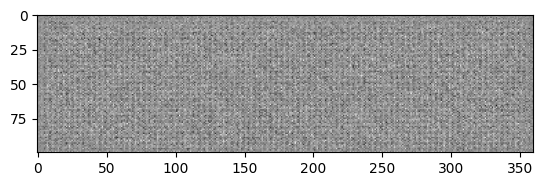

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

#### Discriminator

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=(100,360,1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=(100,360,1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    for layer in model.layers:
      print(layer.name)
      print(layer.input_shape)
      print(layer.output_shape)

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

conv2d
(None, 100, 360, 1)
(None, 50, 180, 64)
leaky_re_lu_3
(None, 50, 180, 64)
(None, 50, 180, 64)
dropout
(None, 50, 180, 64)
(None, 50, 180, 64)
conv2d_1
(None, 50, 180, 64)
(None, 25, 90, 128)
leaky_re_lu_4
(None, 25, 90, 128)
(None, 25, 90, 128)
dropout_1
(None, 25, 90, 128)
(None, 25, 90, 128)
flatten
(None, 25, 90, 128)
(None, 288000)
dense_1
(None, 288000)
(None, 1)
tf.Tensor([[0.00029145]], shape=(1, 1), dtype=float32)


# Defining loss and optimisers

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Discriminator Loss
This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## Generator Loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      print(images.shape)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      print(image_batch.shape)
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

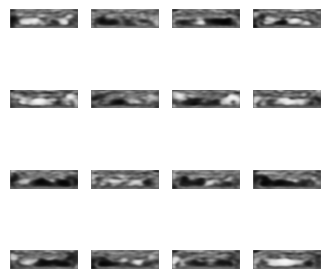

Time for epoch 3 is 2364.149406194687 sec
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24,

In [ ]:
train(train_dataset, EPOCHS)